In [4]:
import numpy as np
import pandas as pd
import matplotlib
import cv2
import torchvision
import torch
from torch import Tensor, cat, sigmoid, exp, stack, max
from model import Darknet, Tail, Head

image = cv2.imread("/home/ivan/Pictures/gs/ag-Bolshevik/Belarus/Minsk-region/Armyanskaya-5/1a1FRZu__nMC9ibd8eQnTFby6eJYuQzgW.jpg")
image = cv2.resize(image, (416, 416), interpolation=cv2.INTER_LINEAR)
image = torch.Tensor(image).permute(2, 0, 1)

weight_file_path = "/home/ivan/sets/best_big/backup/v3single_last.weights"
with open(weight_file_path, "rb") as f:
    header = np.fromfile(f, dtype=np.int32, count=5)
    header_info = header
    seen = header[3]
    weights = np.fromfile(f, dtype=np.float32)
print(seen)


darknet = Darknet()
tail = Tail(1, [3, 3, 3])


def parse_darknet_weight(flatten_weights, model):
    checkpoint = model.state_dict()
    new_dict = checkpoint.copy()
    endings = ["bias", "weight", "running_mean", "running_var"]
    previous = ""
    for layer in checkpoint:
        if previous != ".".join(layer.split(".")[:-1]):
            previous = ".".join(layer.split(".")[:-1])
            if layer.split(".")[-1] in ["bias", "weight", "running_mean", "running_var"]:
                unordered_keys = [".".join(layer.split(".")[:-1]) + "." + ending for ending in endings]
                if all(unordered_key in checkpoint.keys() for unordered_key in unordered_keys):
                    for unordered_key in unordered_keys:
                        size_expected_by_model = checkpoint[unordered_key].size()
                        length_expected_by_model = np.prod(size_expected_by_model)
                        new_dict[unordered_key] = \
                            torch.from_numpy(flatten_weights[:length_expected_by_model]).view(size_expected_by_model)
                        flatten_weights = flatten_weights[length_expected_by_model:]
                    chunks = unordered_key.split('.')
                    chunks[-2] = str(int(chunks[-2]) - 1)
                    unordered_key = ".".join(chunks[:-1])+".weight"
                    size_expected_by_model = checkpoint[unordered_key].size()
                    length_expected_by_model = np.prod(size_expected_by_model)
                    new_dict[unordered_key] = \
                        torch.from_numpy(flatten_weights[:length_expected_by_model]).view(size_expected_by_model)
                    flatten_weights = flatten_weights[length_expected_by_model:]
                elif (unordered_keys[0] in checkpoint.keys()) & (unordered_keys[1] in checkpoint.keys()):
                    for unordered_key in unordered_keys[:2]:
                        size_expected_by_model = checkpoint[unordered_key].size()
                        length_expected_by_model = np.prod(size_expected_by_model)
                        new_dict[unordered_key] = \
                            torch.from_numpy(flatten_weights[:length_expected_by_model]).view(size_expected_by_model)
                        flatten_weights = flatten_weights[length_expected_by_model:]
    return new_dict, flatten_weights


def parse_tail_weight(flatten_weights, model):
    checkpoint = model.state_dict()
    new_dict = checkpoint.copy()
    endings = ["bias", "weight", "running_mean", "running_var"]
    previous = ""
    for i in range(3):
        for layer_type in ["harmonics", "splitted_harmonic", "preludes", "equalizers_for_routes"]:
            for layer in checkpoint:
                if layer_type in layer:
                    if int(layer.split(".")[1]) == i:
                        if previous != ".".join(layer.split(".")[:-1]):
                            previous = ".".join(layer.split(".")[:-1])
                            if layer.split(".")[-1] in ["bias", "weight", "running_mean", "running_var"]:
                                unordered_keys = [".".join(layer.split(".")[:-1]) + "." + ending for ending in endings]
                                if all(unordered_key in checkpoint.keys() for unordered_key in unordered_keys):
                                    for unordered_key in unordered_keys:
                                        size_expected_by_model = checkpoint[unordered_key].size()
                                        length_expected_by_model = np.prod(size_expected_by_model)
                                        new_dict[unordered_key] = \
                                            torch.from_numpy(flatten_weights[:length_expected_by_model]).view(
                                                size_expected_by_model)
                                        flatten_weights = flatten_weights[length_expected_by_model:]
                                    chunks = unordered_key.split('.')
                                    chunks[-2] = str(int(chunks[-2]) - 1)
                                    unordered_key = ".".join(chunks[:-1])+".weight"
                                    size_expected_by_model = checkpoint[unordered_key].size()
                                    length_expected_by_model = np.prod(size_expected_by_model)
                                    new_dict[unordered_key] = \
                                        torch.from_numpy(flatten_weights[:length_expected_by_model]).view(
                                            size_expected_by_model)
                                    flatten_weights = flatten_weights[length_expected_by_model:]
                                elif (unordered_keys[0] in checkpoint.keys()) & \
                                        (unordered_keys[1] in checkpoint.keys()):
                                    for unordered_key in unordered_keys[:2]:
                                        print(unordered_key)
                                        size_expected_by_model = checkpoint[unordered_key].size()
                                        length_expected_by_model = np.prod(size_expected_by_model)
                                        new_dict[unordered_key] = \
                                            torch.from_numpy(flatten_weights[:length_expected_by_model]).view(
                                                size_expected_by_model)
                                        flatten_weights = flatten_weights[length_expected_by_model:]
    return new_dict, flatten_weights


darknet_state_dict, unused_weights = parse_darknet_weight(weights, darknet)
tail_state_dict, unused_weights = parse_tail_weight(unused_weights, tail)


81180009
preludes.0.bias
preludes.0.weight
preludes.1.bias
preludes.1.weight
preludes.2.bias
preludes.2.weight


In [6]:
darknet.load_state_dict(darknet_state_dict)

<All keys matched successfully>

In [7]:
tail.load_state_dict(tail_state_dict)

<All keys matched successfully>

In [55]:
head = Head(Tensor([[120, 93],  [84,191], [238,186]]),1)

In [56]:
probabilities = (head(features)[2][...,0]*head(features)[2][...,1])

In [58]:
import torchvision

In [57]:
max(probabilities)

tensor(0.9411, grad_fn=<MaxBackward1>)

head(features)[0]

In [54]:
features = tail(darknet(image.unsqueeze(dim=0)))[2]

In [38]:
len(Tensor([[120, 93],  [84,191], [238,186]]))

3

In [68]:
sizes = cat((head(features)[0]* Tensor([416,416]) - head(features)[1]/2,head(features)[0]* Tensor([416,416]) + head(features)[1]/2),dim=-1)

In [90]:
boxes = cat((sizes[...,0].view(-1,1),sizes[...,1].view(-1,1),sizes[...,2].view(-1,1),sizes[...,3].view(-1,1)), dim=1)

In [115]:
probabilities.view(-1)>0.7

tensor([False, False, False,  ..., False, False, False])

In [116]:
boxes[probabilities.view(-1)>0.7].detach

tensor([[ 86.5654, 196.6974, 196.9924, 366.8466],
        [-10.2934, 227.5006, 259.4768, 347.1822]], grad_fn=<IndexBackward>)

In [112]:
boxes[torchvision.ops.nms(boxes, probabilities.view(-1,1), 0.45)].size()

torch.Size([428, 4])

In [61]:
image.shape

torch.Size([3, 416, 416])

In [103]:
from src.boxes_manipulations import convert_to_matplotlib

In [104]:
image = cv2.imread("/home/ivan/Pictures/gs/ag-Bolshevik/Belarus/Minsk-region/Armyanskaya-5/1a1FRZu__nMC9ibd8eQnTFby6eJYuQzgW.jpg")
image = cv2.resize(image, (416, 416), interpolation=cv2.INTER_LINEAR)

In [124]:
ii=(probabilities.view(-1)[torchvision.ops.nms(boxes, probabilities.view(-1,1), 0.45)]>0.1)

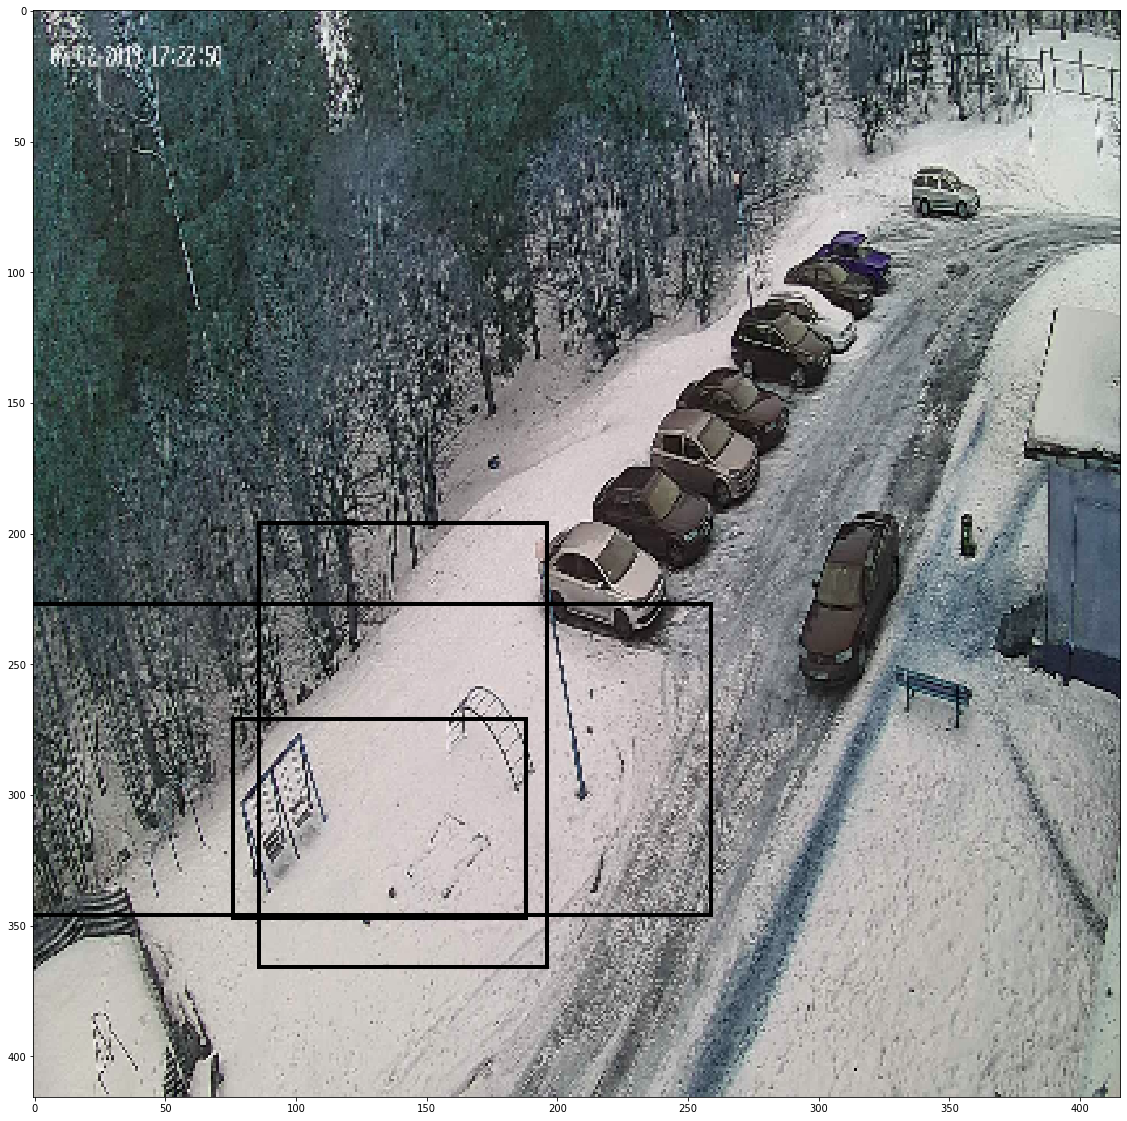

In [125]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1)
for xmi,ymi, xma, yma in boxes[torchvision.ops.nms(boxes, probabilities.view(-1,1), 0.45)][ii].detach().numpy():
       ax.add_patch(plt.Rectangle((int(xmi), int(ymi)), int(xma-xmi), int(yma-ymi), linewidth=4, fill=False))
plt.imshow(image)
plt.show()

In [107]:
import matplotlib.pyplot as plt